<a href="https://colab.research.google.com/github/dragoa/MachineLearning/blob/main/DL/L5_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

### Import main libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
import keras
from keras import layers, losses
from keras.datasets import fashion_mnist, mnist
from keras.models import Model


Autoencoders are a data compression algorithms made up of a compression and decompression functions.
Two interesting practical applications of autoencoders are data denoising, and dimensionality reduction for data visualization.

 The lab is organized as following:

  1.1 Dataset loading;

  1.2 Pre-processing (Dataset normalization, splitting and label pre-processing);

  1.3 Deep Autoencoder implementation;

  1.4 Autoencoder training;

  1.5 Autoencoder testing.


  Similarly with a Convolutional Autoencoder.

  You will visualize the latent representation and use such method for image denoising with synthetic noise.






### Load data
Load the data you want experiment with (e.g. fashion and mnist). Experiment with different dataset, how the architectures should be changed? Do you notice any difference in the results (e.g. in terms of the loss function)?

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(x_train.shape)
print(x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


Normalize and add one channel.
One common practice in training a Neural Network is to normalize the images by dividing each pixel value by the maximum value that we can have (e.g. 225).<br> The purpose of this is to obtain values between 0 and 1.<br>
Normalizing the data generally speeds up learning and leads to faster convergence.

In [3]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    # normalize
    array = array.astype("float32") / 255.0

    # reshape and add 1 dimension channel
    array = np.reshape(array, (len(array), array.shape[1], array.shape[2], 1))
    return array

# Normalize and reshape the data
x_train = preprocess(x_train)
x_test = preprocess(x_test)

## Visualize data

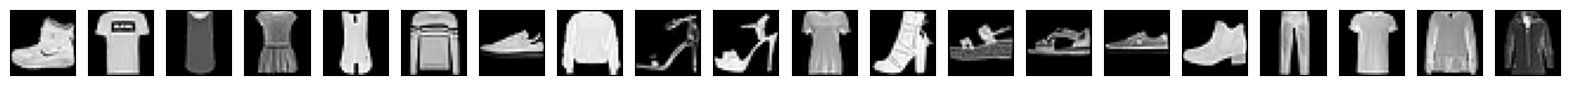

In [4]:
def plot_imgs(imgs, n= 20):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # Display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plot_imgs(x_train)

### Define Deep Autoencoder with Dense layers

Models in Keras are defined as a sequence of layers. The things to choose when defining the architecture are many:
 - number of layers
 - type of layers
 - size of layers
 - type of non-linearity (activation functions)
 - whether or not to add regularization

Here we will use only fully-connected (dense) layers, so the type of layer is fixed. Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class, which takes as parameters the number of neurons (which is the **dimension of the output**).

The following image is sketch of the general architecure:

![Deep Autoencoder](https://www.compthree.com/images/blog/ae/ae.png)

The Autoencoder are trained to reconstruct the input image comparing the output and the input pixel per pixel.

Define a class extending [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), then we define the [sequence](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) of layers for both encoder and decoder. Note than the Encoder and Decoder  should be as symmetric as possible.

To define your own model, you must implement the **init** and **call** methods:
- **init** instantiate and initialize the model layers.
- **call** define the flow of computation calling the layers sequentially.

In [5]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim

    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])


    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## Compile model

Define the autoencoder of fully connected layers.
After having created a model you need to **compile** it. During the compilation phase you must specify some parameters related to optimization of the model:
 - The `optimizer`. For the following exercise you should use [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD), initialized with the default learning rate.
 - The `loss` function. For the reconstruction you can use the [mean squared error](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) loss.
 - A list of `metrics`: common score functions which you want keras to report at each training epoch.



In [6]:
latent_dim = 10
autoencoder = Autoencoder(latent_dim)

# set optimizer and loss function
autoencoder.compile(optimizer='sgd', loss=losses.MeanSquaredError())

The **fit** method perform the training procedure and return a *dict* containing the metric values at each epoch.

In [7]:
epochs = 5
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                shuffle=True,
                validation_data=(x_test, x_test))

autoencoder.summary()

Epoch 1/5
1875/1875 [==============================] - 19s 7ms/step - loss: 0.1701 - val_loss: 0.1690
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1694 - val_loss: 0.1682
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1685 - val_loss: 0.1671
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1669 - val_loss: 0.1648
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1622 - val_loss: 0.1559
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                109386    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            110160    
                                                                 
Total params: 219546 (857.60 KB)
Trainable params: 219546 (857.60 KB)
Non-tr

Note that here our goal is to reconstruct the images, so the targets passed to the model should be the images itself, that's why the data are defined as couples *(x_train, x_train)*.

Plot the loss function for each epoch for both validation and traning data. See [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History).

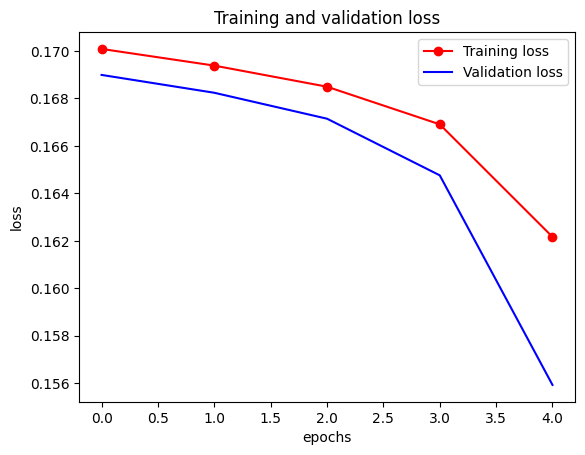

In [8]:
def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(loss, marker="o", c="red", label='Training loss')
  plt.plot(val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend()

  plt.show()

plot_loss(history)

Test the learnt model on the test set. To test an autoencoder you must visualize the input and its reconstruction.

In [9]:
# Compute the reconstruction on the test set
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

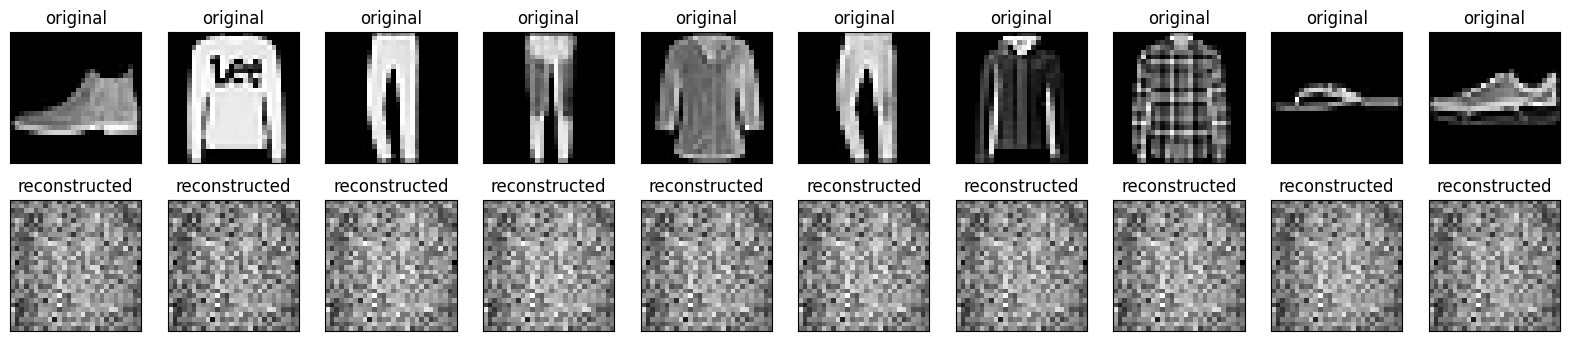

In [10]:
def plot_examples(x_test, decoded_imgs, n = 10):

  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()


# visualize results
plot_examples(x_test,decoded_imgs )

Visualize the latent representation. If it is 2-dimensional plot as it is, otherwise apply PCA dimensionality reduction. Try to visualize the points with a different color for each class, what do you observe?

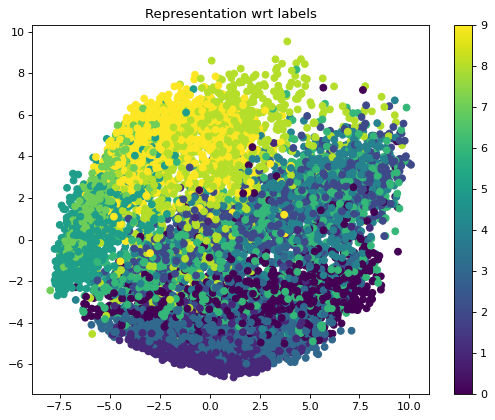

In [18]:
def plot_pca_latent_space(encoded_imgs, labels):

  # Flatten the encoded images if they are not already 2D
  if len(encoded_imgs.shape) > 2:
    encoded_imgs = np.reshape(encoded_imgs, (encoded_imgs.shape[0], -1))

  pca = PCA(n_components=2)
  data_reduced = pca.fit_transform(encoded_imgs)

  x, y = data_reduced[..., 0], data_reduced[..., 1]

  plt.figure(figsize=(8, 6), dpi=80)
  plt.scatter(x, y, c=labels, cmap='viridis')
  plt.title("Representation wrt labels")
  plt.colorbar()
  plt.show()

def plot_latent_space(encoded_imgs, labels):

  assert encoded_imgs.shape[-1] == 2

  x, y = encoded_imgs[..., 0], encoded_imgs[..., 1]

  plt.figure(figsize=(8, 6), dpi=80)
  plt.scatter(x, y, c=labels, cmap='viridis')
  plt.title("Representation wrt labels")
  plt.colorbar()
  plt.show()

if latent_dim==2:
  plot_latent_space(encoded_imgs, y_test)
else:
  plot_pca_latent_space(encoded_imgs, y_test)

Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding image for each of these points. This gives us a visualization of the latent manifold that "generates" the data.

In [12]:
def plot_manifold(decoder, n=15):
  # Display a 2D manifold of the digits
  n = 15  # figure with 15x15 digits
  img_size = 28
  figure = np.zeros((img_size * n, img_size * n))
  # We will sample n points within [-15, 15] standard deviations
  grid_x = np.linspace(-15, 15, n)
  grid_y = np.linspace(-15, 15, n)

  for i, yi in enumerate(grid_x):
      for j, xi in enumerate(grid_y):
          z_sample = np.array([[xi, yi]])
          print(z_sample.shape)
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_size, img_size)
          figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = digit

  plt.figure(figsize=(10, 10))
  plt.imshow(figure)
  plt.show()

if latent_dim==2:
  plot_manifold(autoencoder.decoder)

Experiment with different latent dimensions and comment the results you obtain.
You may try different architectures.
We ask you to add one layer, again,discuss the results.

### Optional
It is a good practice repeat the same experiments different times with different random seeds, so we can evaluate also the stability of our method. Try to repeat the same experiments with 5 random seeds initialized with [tf.keras.utils.set_random_seed](https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed).

### Define Autoencoder with Convolutional layers

we are going to create a convolutional model in Keras.
Usually a convolutional model is made by two subsequent part:
* A convolutional part
* A fully connected

We can show an example of the general structure in the next picture:

![Convolutional autoencoder](https://149695847.v2.pressablecdn.com/wp-content/uploads/2020/07/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png)



Usually the convolutional part is made by some layers composed by
* convolutional layer: performs a spatial convolution over images
* pooling layer: used to reduce the output spatial dimension from $n$ to 1 by averaging the $n$ different value or considering the maximum between them
* dropout layer: applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training.



Implement a Model as you have done for the deep autoencoder. Here try to use [Convolutions](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), [Batch Normalizations](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) and [Pooling layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D).

The Decoder should be specular to the Encoder, therefore the Convolutional layers should be replaced with [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose). Define the list of layers in the Encoder and the Decoder.
On the first try, reproduce the architecture depicted above.

In [13]:
class ConvAutoencoder(Model):
  def __init__(self, latent_dim):
    super(ConvAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      # Fill here #
    ])
    self.decoder = tf.keras.Sequential([
     # Fill here #
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [14]:
latent_dim = 64
autoencoder = ConvAutoencoder(latent_dim)

#  set optimizer and loss function
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

epochs = 10
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

autoencoder.summary()

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/1

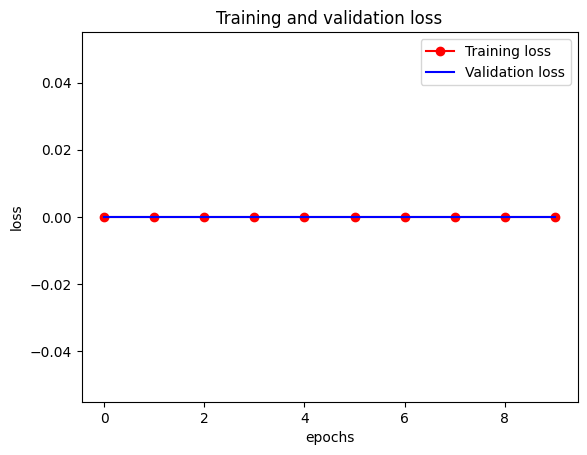

In [15]:
plot_loss(history)

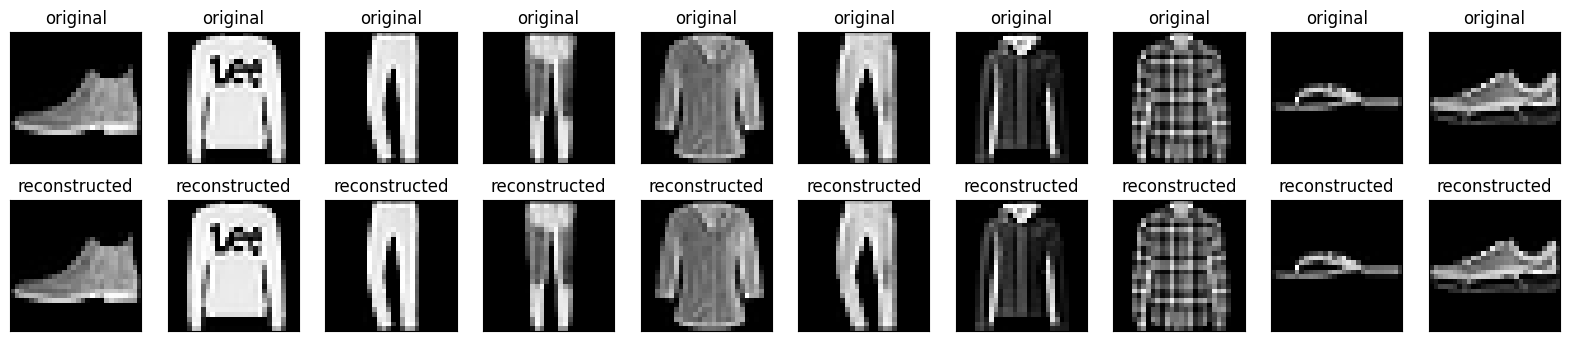

In [16]:
plot_examples(x_test,decoded_imgs)

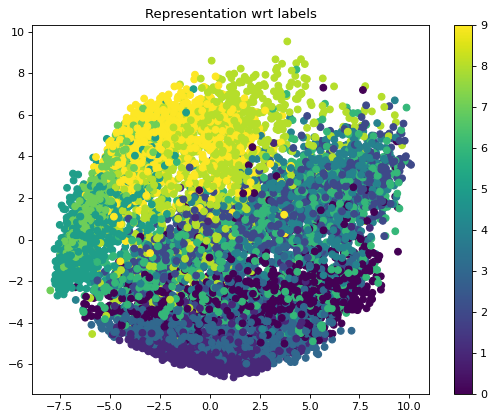

In [19]:
if latent_dim==2:
  plot_latent_space(encoded_imgs, y_test)
else:
  plot_pca_latent_space(encoded_imgs, y_test)

Do you see any difference between the Deep Autoencoder and the Convolutional one? Training time, Reconstruction loss, Complexity of the model (e.g. number of parameters).

## Denoising (optional)

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy images to clean images.

Here's how we will generate synthetic noisy images: we just apply a gaussian noise matrix and clip the images between 0 and 1.



In [20]:
def add_noise(img, noise_factor = 0.5):
  # add gaussian noise
  img_noisy = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
  img_noisy = np.clip(img_noisy, 0., 1.)
  return img_noisy

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

In [24]:
latent_dim = 64
autoencoder = ConvAutoencoder(latent_dim)

# set optimizer and loss function
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

epochs = 10
history = autoencoder.fit(x_train_noisy, x_train_noisy,
                epochs=epochs,
                shuffle=True,
                validation_data=(
                    x_test_noisy, x_test_noisy
                ))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/1

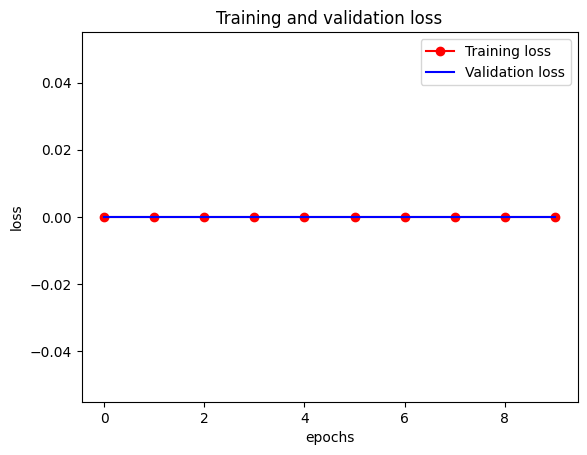

In [29]:
plot_loss(history)

In [27]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

autoencoder.summary()

Model: "conv_autoencoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   multiple                  0         
                                                                 
 sequential_7 (Sequential)   multiple                  0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


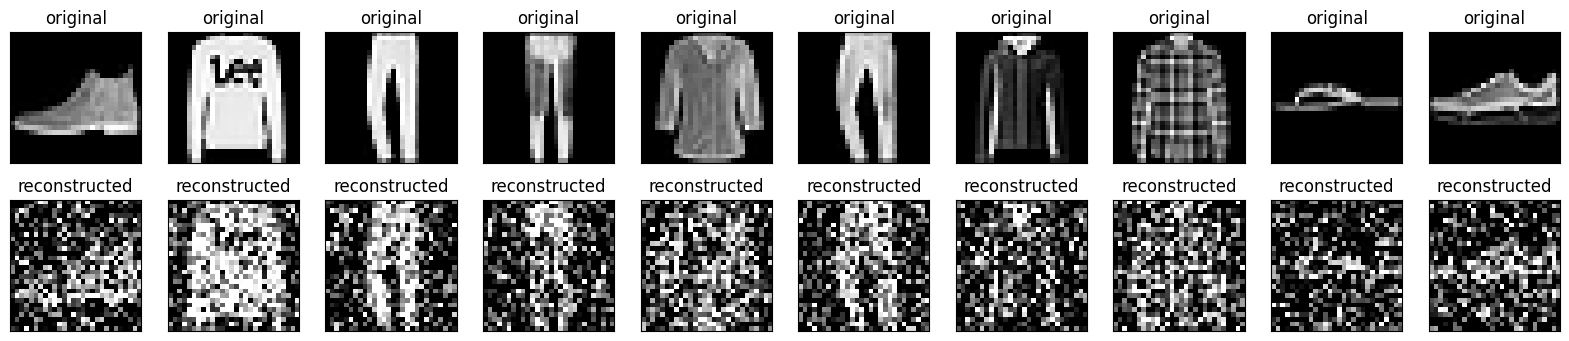

In [28]:
plot_examples(x_test,decoded_imgs)

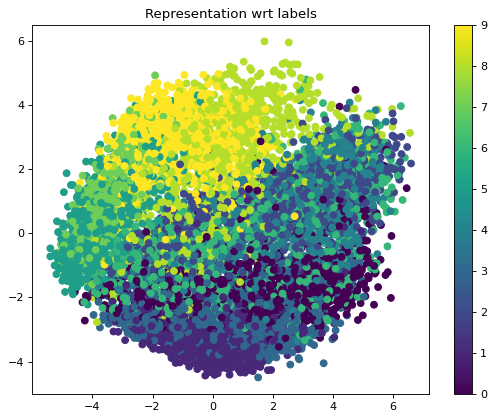

In [30]:
if latent_dim==2:
  plot_latent_space(encoded_imgs, y_test)
else:
  plot_pca_latent_space(encoded_imgs, y_test)